# Data Imputation

By Atwine Mugume Twinamatsiko

The issue in this notebook is that there are different methods of imputing data but not all can do well when you are working with live project data that can affect reall humans at the execution of the final application.

As a result I am going to use the method refered to in this article to work through m y data so that I will be able to give a proper representation of the information detailed in the data files I have.

This is the article I am going to use;

- First I worked with the data in TableauPrep in order to organize it in a better way :: Tableau Prep makes the data cleaning process much easier for me and I would recommend it to many.

[Multivariate Imputation by Chained Equation](https://towardsdatascience.com/stop-using-mean-to-fill-missing-data-678c0d396e22)

[GitHub Link](https://github.com/eltonlaw/impyute)

[Fancy Impute](https://github.com/iskandr/fancyimpute)

[Imputena](https://github.com/macarro/imputena)

In [1]:
#note when the data is finally imported you will have to separate the numeric from the categorical
#then you will use the MICE method on the new set up to help impute that data.

In [1]:
#lets import the libraries that we will need in this code
import numpy as np
import pandas as pd
import missingno as mno
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [24]:
#lets read in the data
dt = pd.read_csv('draft2.csv')

In [26]:
dt.blood_test_result.isnull().sum()

0

In [3]:
#what is the dimension of the data
dt.shape

(259, 472)

So we have 242 dimensions minus the label, once we label the data we will have more of this data to play with

In [4]:
dt.head(5)

,month_of_birth,year_of_birth,current_age,region,type_of_place_of_residence,higest_level_of_education,time_to_water_source,household_has_radio,religion,tribe,...,Age_of_most_recent_partner,Age_of_2nd_to_most_recent_partner,Age_of_3rd_to_most_recent_partner,Total_lifetime_number_of_sex_partners,Concurrent_sexual_partners,Cumulative_concurrent_sexual_partners,Weight_for_Domestic_Violence_(6_decimals),Experienced_any_severe_violence_(D105D-F)_by_wife/partner,"Experienced_any_sexual_violence_(D105H-I,K)_by_wife/partner",Gender
0,7,1985,25,kampala,urban,higher,NaN,yes,sda,iteso,...,26.0,18.0,NaN,6.0,0.0,1.0,600954.0,0.0,1.0,Female
7,10,1992,18,east central,rural,secondary,60.0,no,anglican/protestant,basoga,...,NaN,NaN,NaN,NaN,NaN,NaN,706444.0,NaN,NaN,Female
15,7,1984,26,mid eastern,rural,primary,20.0,yes,anglican/protestant,banyoro,...,32.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,Female
29,12,1966,44,central 1,rural,no education,40.0,yes,catholic,baganda,...,26.0,NaN,NaN,3.0,NaN,NaN,1078559.0,0.0,0.0,Female
37,8,1989,21,mid western,rural,primary,90.0,yes,catholic,banyoro,...,NaN,NaN,NaN,1.0,NaN,NaN,1349895.0,0.0,0.0,Female


In [5]:
list(dt.columns)

['month_of_birth',
 'year_of_birth',
 'current_age',
 'region',
 'type_of_place_of_residence',
 'higest_level_of_education',
 'time_to_water_source',
 'household_has_radio',
 'religion',
 'tribe',
 'number_of_household_members',
 'education_attainment',
 'relationship_to_household_head',
 'sex_of_household_head',
 'age_of_household_head',
 'frequency_of_listening_radio',
 'number_of_trips_last12month',
 'wealth_index_factor_score',
 'total_children',
 'sons_elsewhere',
 'daughters_elsewhere',
 'number_of_injections',
 'injections_administered_by_healthworker',
 'place_of_injection',
 'current_marital_status',
 'leaving_living_with_partner',
 'number_of_unions',
 'currently_living',
 'number_of_other_wives',
 'months_of_first_cohabitation',
 'year_of_first_cohabitation',
 'age_at_first_cohabitation',
 'age_at_first_sex',
 'months_since_last_sex',
 'recent_sexual_activity',
 'months_of_abstinence',
 'reason_for_no_sex_husband_has_other_women',
 'reason_no_sex_tired_notinmood',
 'responde

<AxesSubplot:>

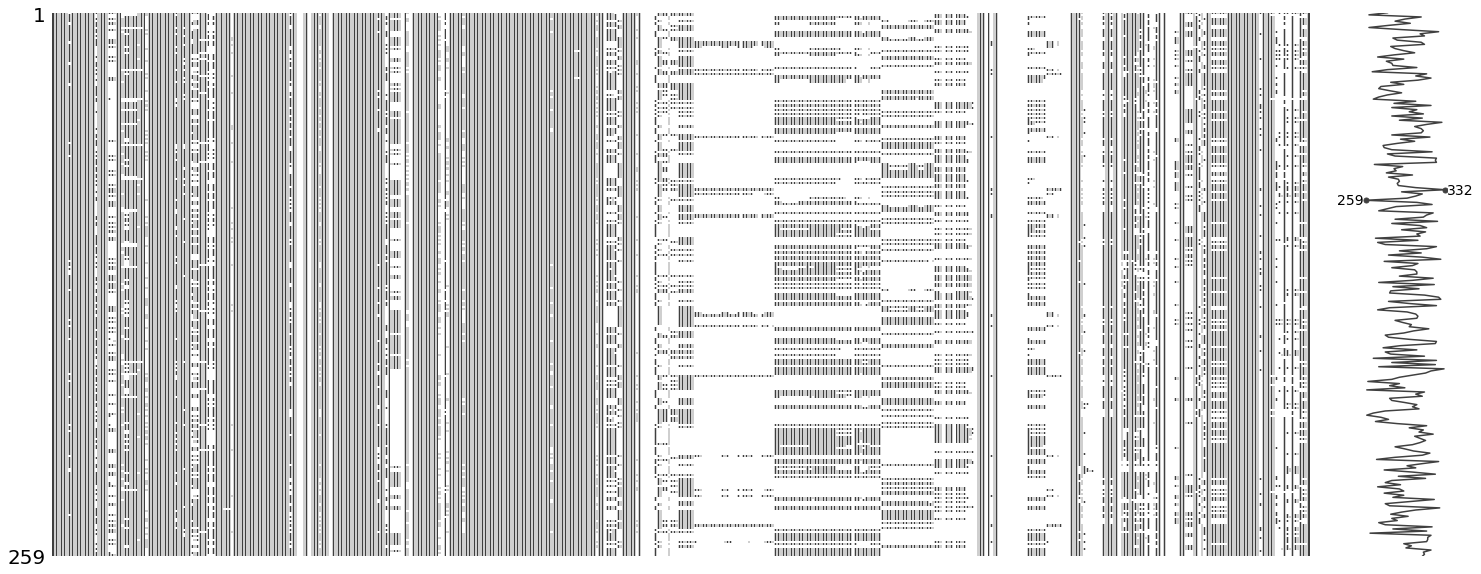

In [6]:
mno.matrix(dt)
#the white spaces are the ones that represent data that is missing in the matrix
#the full black columns represent the data that is present in the matrix

In [7]:
#before we label the data we are going to use the method mentioned above to help us
#this method will assist us in replacing the missing data
#but first I have to separate the data types the numerical from the categorical ones.

In [8]:
dt.dtypes.unique()
#the data types below show what kind of data we are dealing with.
#we can see the dtypes are common, and some are not included like datetime or images.

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [9]:
# now importing impute
from impyute.imputation.cs import mice, random, mode

In [10]:
#checking the processors used

import os
import re
import subprocess


def available_cpu_count():
    """ Number of available virtual or physical CPUs on this system, i.e.
    user/real as output by time(1) when called with an optimally scaling
    userspace-only program"""

    # cpuset
    # cpuset may restrict the number of *available* processors
    try:
        m = re.search(r'(?m)^Cpus_allowed:\s*(.*)$',
                      open('/proc/self/status').read())
        if m:
            res = bin(int(m.group(1).replace(',', ''), 16)).count('1')
            if res > 0:
                return res
    except IOError:
        pass

    # Python 2.6+
    try:
        import multiprocessing
        return multiprocessing.cpu_count()
    except (ImportError, NotImplementedError):
        pass

    # https://github.com/giampaolo/psutil
    try:
        import psutil
        return psutil.cpu_count()   # psutil.NUM_CPUS on old versions
    except (ImportError, AttributeError):
        pass

    # POSIX
    try:
        res = int(os.sysconf('SC_NPROCESSORS_ONLN'))

        if res > 0:
            return res
    except (AttributeError, ValueError):
        pass

    # Windows
    try:
        res = int(os.environ['NUMBER_OF_PROCESSORS'])

        if res > 0:
            return res
    except (KeyError, ValueError):
        pass

    # jython
    try:
        from java.lang import Runtime
        runtime = Runtime.getRuntime()
        res = runtime.availableProcessors()
        if res > 0:
            return res
    except ImportError:
        pass

    # BSD
    try:
        sysctl = subprocess.Popen(['sysctl', '-n', 'hw.ncpu'],
                                  stdout=subprocess.PIPE)
        scStdout = sysctl.communicate()[0]
        res = int(scStdout)

        if res > 0:
            return res
    except (OSError, ValueError):
        pass

    # Linux
    try:
        res = open('/proc/cpuinfo').read().count('processor\t:')

        if res > 0:
            return res
    except IOError:
        pass

    # Solaris
    try:
        pseudoDevices = os.listdir('/devices/pseudo/')
        res = 0
        for pd in pseudoDevices:
            if re.match(r'^cpuid@[0-9]+$', pd):
                res += 1

        if res > 0:
            return res
    except OSError:
        pass

    # Other UNIXes (heuristic)
    try:
        try:
            dmesg = open('/var/run/dmesg.boot').read()
        except IOError:
            dmesgProcess = subprocess.Popen(['dmesg'], stdout=subprocess.PIPE)
            dmesg = dmesgProcess.communicate()[0]

        res = 0
        while '\ncpu' + str(res) + ':' in dmesg:
            res += 1

        if res > 0:
            return res
    except OSError:
        pass

    raise Exception('Can not determine number of CPUs on this system')

In [11]:
#let's see the number fo cpus that I have at my disposal to work with the MICE algorithm.
available_cpu_count()

24

In [12]:
#I am going to take some numerical samples so we can test the mice method
dt.select_dtypes(include=np.number).isnull().sum().sort_values(ascending = False).head(15)

Presence of species: malari (Pm)        259
Result of salt test for iodine (PPM)    259
Presence of species: falciparam (Pf)    259
School attendance status                259
Presence of species: ovale (Po)         259
Presence of species: vwax (Pv)          259
Member still in school                  259
Presence of species: CS                 259
Presence of species: CS 1               259
Presence of species: CS 2               259
Result of malaria measurement           259
Result of malaria rapid test            259
Result of measurement - Vitamin A       259
Mean RBP (2 decimals) 1                 259
Vitamin A status 1                      259
dtype: int64

#here I am trying to see how the method of MICE works on small dataset.
x = dt[['Age_of_3rd_to_most_recent_partner','cd4_count']].values
mno.bar(pd.DataFrame(mice(x)))

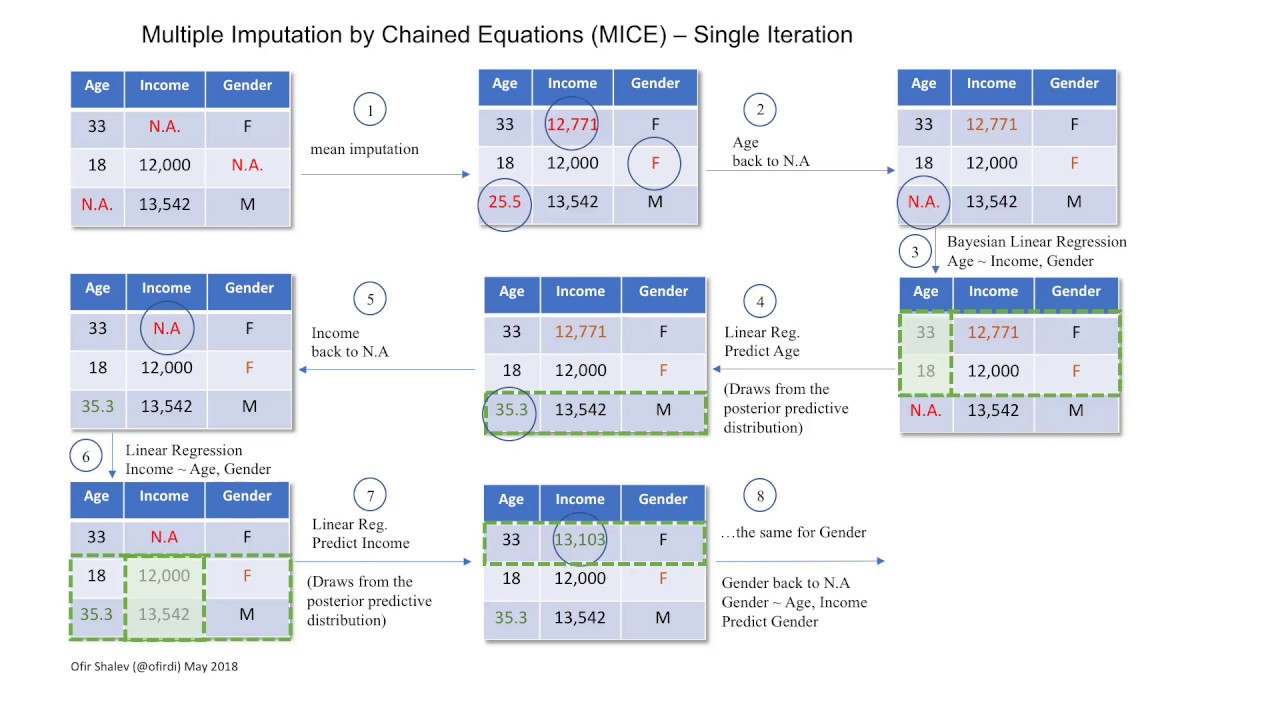

In [13]:
#let's look at the number of numeric variables we have.
dt.select_dtypes(include=np.number).shape

(259, 430)

In [15]:
#i need to first get dummies
okello = pd.get_dummies(dt)

In [23]:
okello

,month_of_birth,year_of_birth,current_age,time_to_water_source,number_of_household_members,age_of_household_head,number_of_trips_last12month,wealth_index_factor_score,total_children,sons_elsewhere,...,Case_Identification_81 8 1,Case_Identification_84 2 1,Case_Identification_8417 1,Case_Identification_8617 1,Case_Identification_90 2 1,Case_Identification_9215 1,Case_Identification_95 5 1,Case_Identification_98 5 1,Case_Identification_9817 1,Gender_Female
0,7,1985,25,NaN,1,26,1.0,193000,0,0,...,0,0,0,0,0,0,0,0,0,1
7,10,1992,18,60.0,11,34,NaN,-61000,0,0,...,0,0,0,0,0,0,0,0,0,1
15,7,1984,26,20.0,4,27,NaN,-71000,7,1,...,0,0,0,0,0,0,0,0,0,1
29,12,1966,44,40.0,8,40,2.0,-77000,7,1,...,0,0,0,0,0,0,0,0,0,1
37,8,1989,21,90.0,5,27,NaN,-55000,2,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2252,8,1964,46,15.0,5,46,NaN,-92000,7,0,...,0,0,0,0,0,0,0,0,0,1
2254,2,1972,39,15.0,3,39,20.0,-5000,10,3,...,0,0,0,0,0,0,0,0,0,1
2260,12,1990,20,30.0,6,20,NaN,-69000,1,0,...,0,0,0,0,0,0,0,0,0,1
2278,11,1979,31,25.0,3,31,1.0,-68000,3,1,...,0,0,0,0,0,0,0,0,0,1


#### DTX

Just running simple tests to see if there are other methods that we can employ.

In [16]:
#I am taking a subset of the data for testing purposes, just 20 rows.
dtx = dt.select_dtypes(include=np.number).head(20)

In [17]:
## I am going to explore imputena
import imputena as imp

In [18]:
#drop all the columns with nothing
(dtx.isnull().sum()/dtx.shape[0]*100).sort_values(ascending=False)

Presence of species: falciparam (Pf)                100.0
Contraceptive_method_currently_used.19              100.0
Education in single years - previous school year    100.0
School attendance status                            100.0
Line number of parent/caretaker                     100.0
                                                    ...  
Dwelling sprayed by: other                            0.0
Dwelling sprayed by: NGO                              0.0
Dwelling sprayed by: private company                  0.0
Dwelling sprayed by: government worker/program        0.0
month_of_birth                                        0.0
Length: 430, dtype: float64

In [19]:
#drop all the columns that totaly have nothing in them.
dtx.dropna(axis = 1,how = 'all', inplace= True)

In [20]:
dtx.shape

(20, 377)

In [22]:
imputed = imp.mice(okello, 5)

ValueError: Found array with 0 sample(s) (shape=(0, 1455)) while a minimum of 1 is required.

In [24]:
#now the issue is turning all the results into something that can turn into a dataframe.
 ok = pd.DataFrame(imputed[0])

<AxesSubplot:>

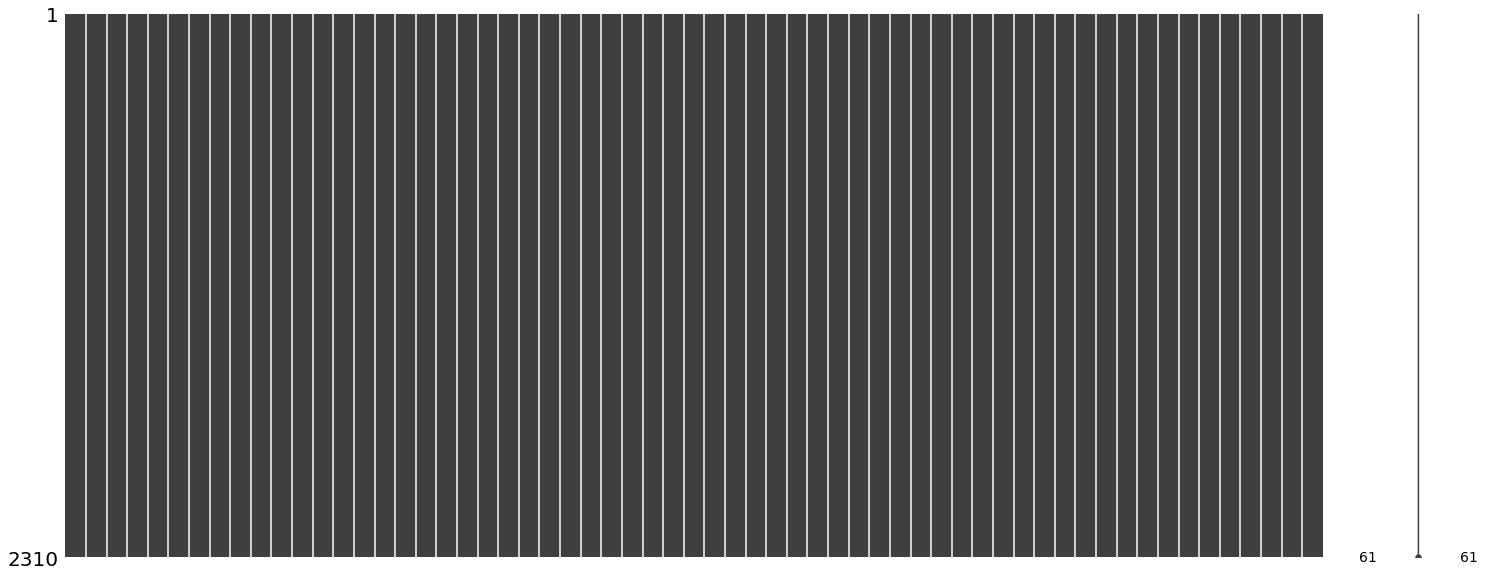

In [25]:
mno.matrix(ok)

In [26]:
ok.to_csv("Okello_MICE.csv",index=False)

In [27]:
ok.head()

,months_since_last_sex,sexualpartners_includinspouse,syplilis_result,Smokingcigarettesinlast24hours,Had_genital_discharge_in_last_12_months,Used_condom_every_time_had_sex_with_most_recent_partner_in_last_12_months,current_marital_status_divorced,current_marital_status_living with partner,current_marital_status_married,current_marital_status_never in union,...,last_partner_hiv_status_don't know,last_partner_hiv_status_negative,last_partner_hiv_status_positive,last_partner_hiv_status_refused to answer,hiv_test_results_don't know,hiv_test_results_negative,hiv_test_results_positive,chances_getting_hiv_don't know,chances_getting_hiv_high,chances_getting_hiv_low
0,3.0,1.0,0.0,0.399862,0.0,1.057119,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,3.0,1.0,0.0,0.399862,0.0,1.057119,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,3.0,1.0,0.0,0.399862,0.0,1.057119,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,3.0,1.0,0.0,0.399862,0.0,1.057119,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,3.0,1.0,0.0,0.399862,0.0,1.057119,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [23]:
#I think its time to try fancy impute.
#I tried the one in the cell below and it did not finish rendering.



## Trial of the above method on the real data

In [24]:
#I am taking a threshold of 1% non missing values
dt.shape[0]*0.01

23.1

In [25]:
#let's drop the columns that have completely no data
dt.dropna(axis=1,thresh=23,inplace = True)

In [26]:
dt.shape

(2310, 241)

In [27]:
dt.head()

,Highest year of education completed,Wealth_index,Age_at_first_sex,current_age,month_of_birth,year_of_birth,region,type_of_place_of_residence,higest_level_of_education,time_to_water_source,...,Age_of_most_recent_partner,Age_of_2nd_to_most_recent_partner,Age_of_3rd_to_most_recent_partner,Total_lifetime_number_of_sex_partners,Concurrent_sexual_partners,Cumulative_concurrent_sexual_partners,Weight_for_Domestic_Violence_(6_decimals),Experienced_any_severe_violence_(D105D-F)_by_wife/partner,"Experienced_any_sexual_violence_(D105H-I,K)_by_wife/partner",Gender
0,1.0,2,20,25,7,1985,kampala,urban,higher,NaN,...,26.0,18.0,NaN,6.0,0.0,1.0,0.600954,0.0,1.0,Female
1,1.0,2,20,25,7,1985,kampala,urban,higher,NaN,...,26.0,18.0,NaN,6.0,0.0,1.0,0.600954,0.0,1.0,Female
2,0.0,2,20,25,7,1985,kampala,urban,higher,NaN,...,26.0,18.0,NaN,6.0,0.0,1.0,0.600954,0.0,1.0,Female
3,1.0,2,20,25,7,1985,kampala,urban,higher,NaN,...,26.0,18.0,NaN,6.0,0.0,1.0,0.600954,0.0,1.0,Female
4,2.0,2,20,25,7,1985,kampala,urban,higher,NaN,...,26.0,18.0,NaN,6.0,0.0,1.0,0.600954,0.0,1.0,Female


<AxesSubplot:>

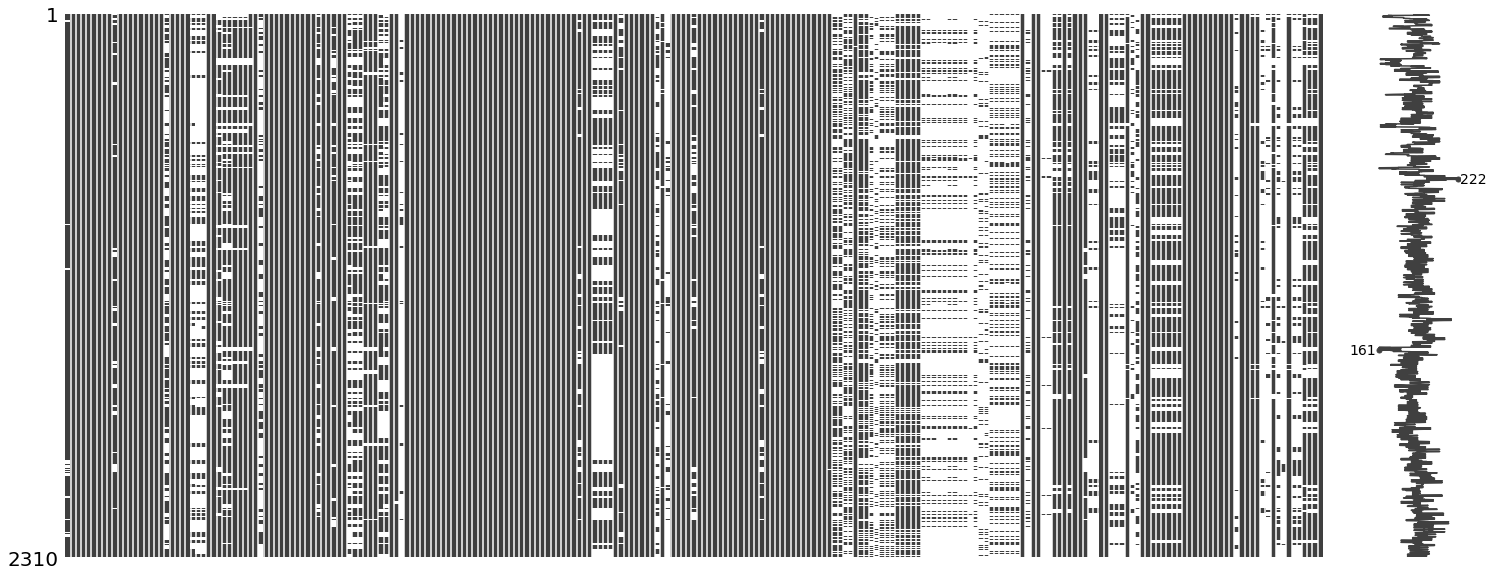

In [28]:
mno.matrix(dt)

<AxesSubplot:>

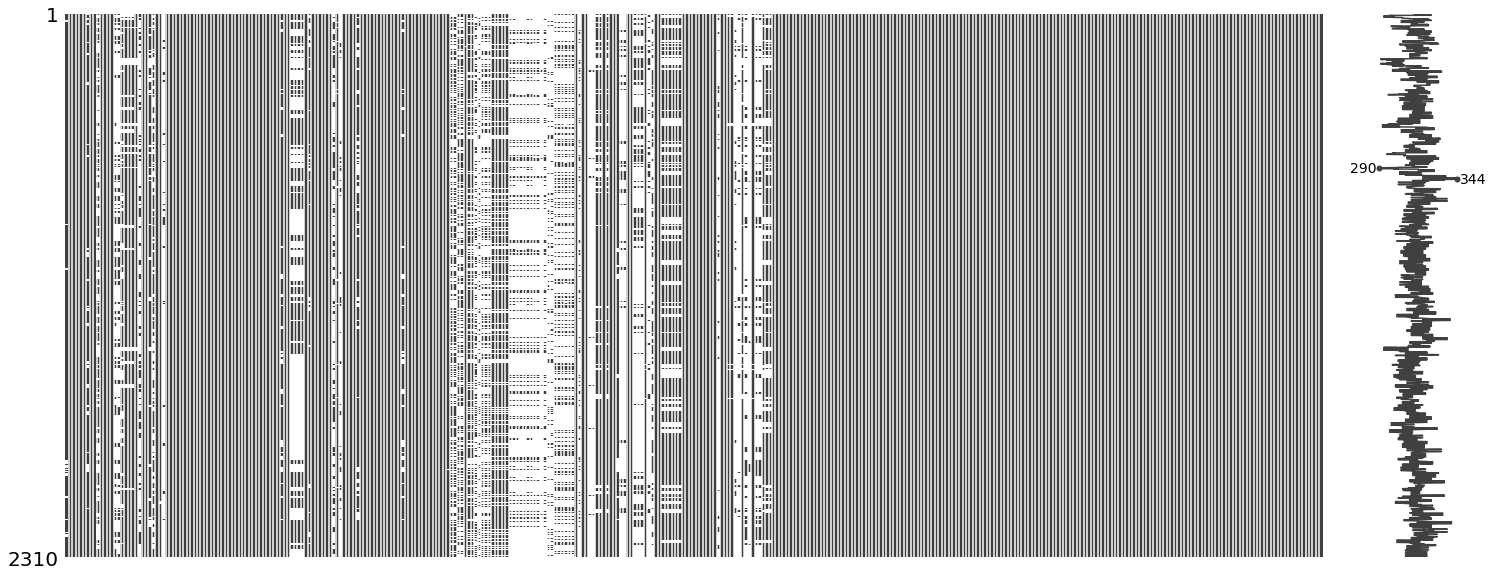

In [29]:
#let me encode all the data
mno.matrix(pd.get_dummies(dt))

In [30]:
dm = pd.get_dummies(dt)

In [ ]:
#let's select the numerical data
 impt = imp.mice(dm,10)

In [ ]:
mno.matrix(impt[0])

In [ ]:
dt_imp = pd.DataFrame(impt[0])

In [ ]:
dt.head()

In [ ]:
dt_imp.head()

In [ ]:
dt_imp.to_csv('draft_3.csv',index=False)

In [ ]:
#at the end of the process make sure the algorithm did not tamper with the datat that did
#did not have any spaces.

#what is then left is to use the logical process to label the data

#after that then we can do some evaluations based on what we have so far.

Below I wanted to know how much memory I was using so that I can know if I am able to make some changes or activate all at the same time.

```
#checking memory usage:
#!/usr/bin/env python
import psutil
# gives a single float value
print(psutil.cpu_percent())
# gives an object with many fields
print(psutil.virtual_memory())
# you can convert that object to a dictionary 
dict(psutil.virtual_memory()._asdict())
# you can have the percentage of used RAM
print(psutil.virtual_memory().percent)
79.2
# you can calculate percentage of available memory
psutil.virtual_memory().available * 100 / psutil.virtual_memory().total
20.8
```

In [ ]:
#let's choose all the variables which are numeric
#imputed = mice(dt.select_dtypes(include=np.number).values)

#after I will need to look at the non numeric variables sort them and then merge the data
#I will merge on the axis = 1
